In [ ]:
base_model = tf.keras.applications.ResNet101(include_top=False,
                                         weights='imagenet')
base_model.trainable = False

In [ ]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x7d5acc566c80>
1 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d5a50d225c0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5a50d21ed0>
3 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5a50d21fc0>
4 <keras.src.layers.core.activation.Activation object at 0x7d5a50d23670>
5 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d5a50d233d0>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d5af0584790>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5af05849d0>
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5af0584940>
9 <keras.src.layers.core.activation.Activation object at 0x7d5af05847f0>
10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5a50d686d0>
11 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5a50d68820>
12 <keras.src

In [ ]:
#Creamos la red convolucional

resnet101 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
resnet101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, None, None, 2048   42658176  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 68351114 (260.74 MB)
Trainable params: 25692938 (98.01 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


In [ ]:
resnet101.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
resnet101.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 90s 316ms/step - loss: 3.1905 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 2/200
235/235 [==============================] - 67s 286ms/step - loss: 2.3047 - accuracy: 0.0916 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 3/200
235/235 [==============================] - 62s 264ms/step - loss: 2.3078 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 4/200
235/235 [==============================] - 60s 255ms/step - loss: 2.3028 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/200
235/235 [==============================] - 60s 256ms/step - loss: 2.3028 - accuracy: 0.0919 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 6/200
235/235 [==============================] - 62s 262ms/step - loss: 2.3028 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 7/200
235/235 [==============================] - 60s 254ms/step - loss: 2.3028 - accuracy: 0.0952 - val_loss: 2.3026 -

resnet101.evaluate(test_batch)

# <font color='lightblue'>Computer Vision</font>

En este notebook veremos como implementar una arquitectura de red para procesar imágenes y que aprenda a obtener patrones (pixeles) que le sirvan para hacer una clasificación.

Usaremos el dataset [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) para distintas tareas. Espero que no les de hambre xd.

Veremos:
1. Clasificación binaria (sigmoid).
2. Clasificación multi-clase (softmax/argmax).
3. Transfer Learning.

## 1. Clasificación binaria de imágenes

Primero cargamos el dataset que contiene solo imágenes de pizzas y steaks(carne) para entrenar una red neuronal convolucional para clasificación binaria.



### Cargamos el dataset

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-10-18 14:59:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 209.85.234.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   257MB/s    in 0.4s    

2023-10-18 14:59:07 (257 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [2]:
!nvidia-smi

Wed Oct 18 14:59:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

>**Nota:** La estructura de carpetas bajo el nombre de train o test y luego bajo el nombre de pizza o steak en cada caso, es el tipo de estructura que necesita `TensorFlow` para saber cual es la carpeta de entrenamiento y testeo, y cual es la clase (etiqueta) de cada grupo de imagen. Con esta clase que encuentra en el nombre de la carpeta es la que va a utilizar para entrenarse.

In [4]:
import os
os.listdir('pizza_steak/test/pizza')

['140016.jpg',
 '80750.jpg',
 '296426.jpg',
 '573054.jpg',
 '3581181.jpg',
 '849291.jpg',
 '2719697.jpg',
 '1180273.jpg',
 '248199.jpg',
 '139952.jpg',
 '1555015.jpg',
 '3784357.jpg',
 '2101820.jpg',
 '3729167.jpg',
 '2003290.jpg',
 '2276783.jpg',
 '2082495.jpg',
 '419962.jpg',
 '1925494.jpg',
 '2615100.jpg',
 '614236.jpg',
 '103708.jpg',
 '1636919.jpg',
 '3392194.jpg',
 '3042459.jpg',
 '3385460.jpg',
 '61656.jpg',
 '2521769.jpg',
 '1342321.jpg',
 '2841536.jpg',
 '226472.jpg',
 '2583389.jpg',
 '2508316.jpg',
 '415551.jpg',
 '418251.jpg',
 '447914.jpg',
 '2236338.jpg',
 '144631.jpg',
 '194784.jpg',
 '2619955.jpg',
 '1594097.jpg',
 '1949644.jpg',
 '1687143.jpg',
 '309892.jpg',
 '1980749.jpg',
 '3375083.jpg',
 '2392727.jpg',
 '1220156.jpg',
 '1503858.jpg',
 '1228171.jpg',
 '3669673.jpg',
 '930553.jpg',
 '1315645.jpg',
 '1412011.jpg',
 '3724416.jpg',
 '2543207.jpg',
 '1691503.jpg',
 '2161321.jpg',
 '1032754.jpg',
 '2111981.jpg',
 '3586083.jpg',
 '2549661.jpg',
 '1445608.jpg',
 '645087.jpg'

In [5]:
# Exploramos las carpetas un poco...
import os

for dir, dirname, files in os.walk('pizza_steak'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: pizza_steak | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: pizza_steak/train | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/train/steak | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/test | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/test/pizza | subdir: [] | cant de imagenes: 250 
Dir: pizza_steak/test/steak | subdir: [] | cant de imagenes: 250 


Vemos que la carpeta `train` contiene 750 imágenes de pizza y 750 de steak.

La carpeta `test` contiene 250 imágenes de pizza y 250 imágenes de steak.

In [6]:
#Guardamos el nombre de las carpetas que haya dentro de train en una lista
# se puede hacer a mano pero a veces son muchas y podemos cometer errores.

classes = [f for f in os.listdir('pizza_steak/train/')]
print(classes)

['pizza', 'steak']


### Visualizamos algunos ejemplos del dataset

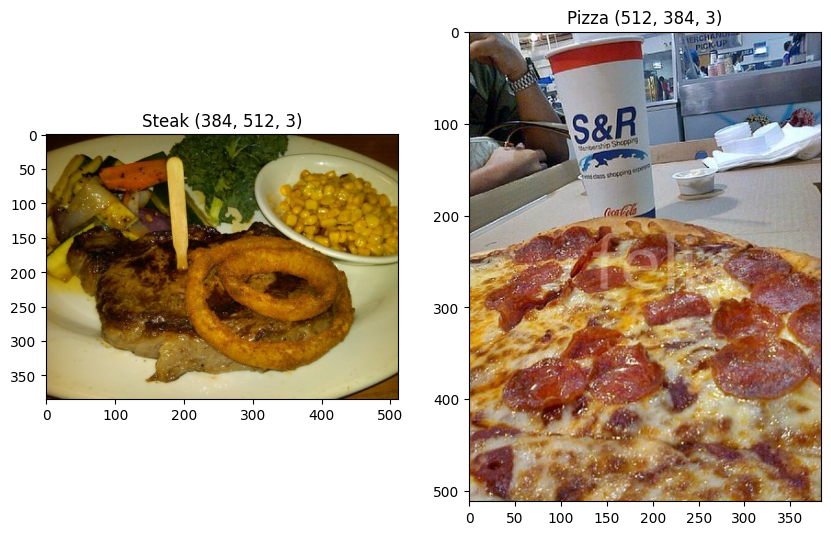

In [7]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,7))
id = random.choice(range(0,749))
plt.subplot(1,2,1)
img_name = [f for f in os.listdir('pizza_steak/train/steak/')][id]
img = plt.imread('pizza_steak/train/steak/'+img_name)
plt.imshow(img)
plt.title('Steak '+str(img.shape))
plt.subplot(1,2,2)
img_name = [f for f in os.listdir('pizza_steak/train/pizza/')][id]
img = plt.imread('pizza_steak/train/pizza/'+img_name)
plt.imshow(img)
plt.title('Pizza '+str(img.shape));

In [8]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('pizza_steak/train/pizza/')]
imagen_prueba = plt.imread('pizza_steak/train/pizza/'+lista_img_pizza[23]) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (384, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


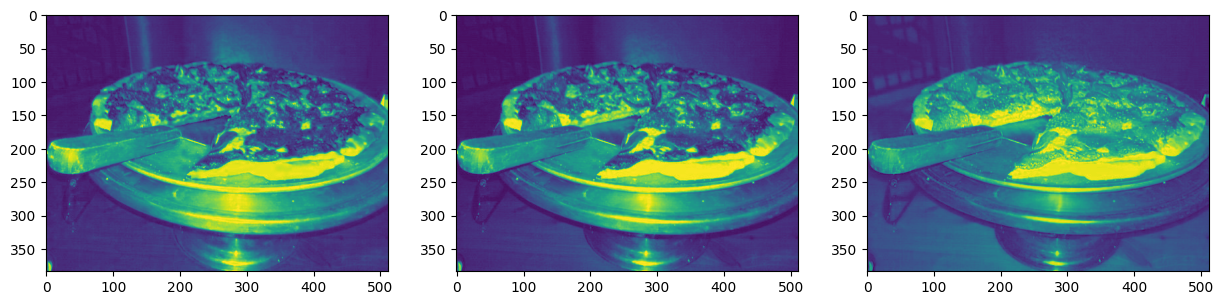

In [9]:
import cv2
imagen_prueba = cv2.imread('pizza_steak/train/pizza/'+lista_img_pizza[22])
b,g,r =  cv2.split(imagen_prueba)
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(b,cmap=None)
plt.subplot(1,3,2)
plt.imshow(g,cmap=None)
plt.subplot(1,3,3)
plt.imshow(r,cmap=None);

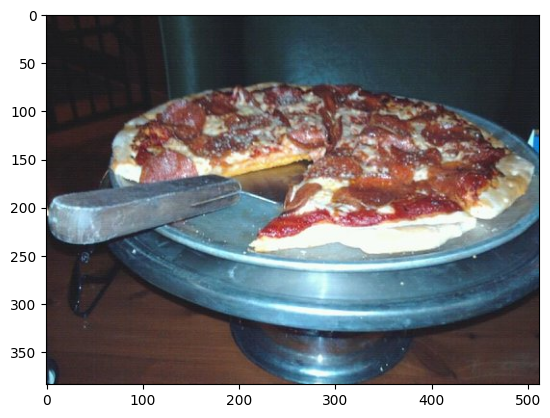

In [10]:
imagen_reconstruida = cv2.merge([r,g,b])
plt.imshow(imagen_reconstruida);

### Creamos la arquitectura de una red neuronal convolucional
Vamos a construir una red neuronal convolucional para encontrar patrones en nuestras imágenes, más específicamente, necesitamos una forma de:
* Cargar la imágenes con TensorFlow
* Preprocesar las imágenes para escalarlas.
* Construir la red convolucional para clasificación
* Compilar la CNN
* Entrenar la CNN con los datos de entrenamiento.

In [11]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary') #multiclass -> 'categorical' [001,100,010]
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [12]:
imagenes, etiquetas = train_batch[0]
print(len(imagenes),len(etiquetas))

32 32


In [13]:
classes

['pizza', 'steak']

In [14]:
etiquetas

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [15]:
import tensorflow as tf
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=((224,224,3))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38634241 (147.38 MB)
Trainable params: 38634241 (147.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Observamos que la cantidad de parámetros en una red fully connected, con solo capas profundas para entrenar con imágenes, resulta muy grande. Y con esto crece la necesidad de poder de computo a la vez que la red tiene que aprender pixel a pixel, lo cual lleva mucho más tiempo.

Una solución a esto es incorporar capas de filtrado, que filtren solo aquella información de la imagen que la red "crea" que es importante. Con esto la cantidad de parámetros se reduce a solo los parametros de dichos filtros, que resultan en menor cantidad y tiempo de procesamiento.

In [16]:
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.20)),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 5)       140       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 5)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 5)       230       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 5)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 5)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 5)        

In [17]:
## Compilamos el modelo
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
## Entrenamos el modelo
model_0.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
47/47 [==============================] - 21s 183ms/step - loss: 0.5979 - accuracy: 0.6673 - precision: 0.6916 - recall: 0.6040 - val_loss: 0.5248 - val_accuracy: 0.7220 - val_precision: 0.7761 - val_recall: 0.6240
Epoch 2/100
47/47 [==============================] - 8s 173ms/step - loss: 0.5493 - accuracy: 0.7413 - precision: 0.7693 - recall: 0.6893 - val_loss: 0.5049 - val_accuracy: 0.7560 - val_precision: 0.7540 - val_recall: 0.7600
Epoch 3/100
47/47 [==============================] - 7s 141ms/step - loss: 0.5312 - accuracy: 0.7447 - precision: 0.7640 - recall: 0.7080 - val_loss: 0.4955 - val_accuracy: 0.7740 - val_precision: 0.7842 - val_recall: 0.7560
Epoch 4/100
47/47 [==============================] - 8s 168ms/step - loss: 0.5182 - accuracy: 0.7533 - precision: 0.7802 - recall: 0.7053 - val_loss: 0.4873 - val_accuracy: 0.7600 - val_precision: 0.8779 - val_recall: 0.6040
Epoch 5/100
47/47 [==============================] - 8s 162ms/step - loss: 0.5180 - accuracy: 0.746

### Evaluamos el modelo

Para esto vamos a importarlo de la carpeta donde se guardaron los checkpoints.

In [18]:
model_0 = tf.keras.models.load_model('/content/checkpoints/model_0')

In [19]:
model_0.evaluate(test_batch)

16/16 [==============================] - 2s 78ms/step - loss: 0.3430 - accuracy: 0.8560 - precision: 0.8870 - recall: 0.8160


[0.34295156598091125,
 0.8560000061988831,
 0.886956512928009,
 0.8159999847412109]

In [21]:
# Podemos ver las métricas con TensorBoard que guardamos durante el entrenamiento
!tensorboard dev upload --logdir=logs/model_0  #tensorboard --logdir=

2023-10-18 15:14:47.550408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.10/dist-packages/absl/app.p

### Hacemos una predicción

In [22]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

1/1 [==============================] - 0s 176ms/step
[[0.58936197]]


In [23]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

La predicción para la imagen de pizza es: 1.0 


In [24]:
classes

['pizza', 'steak']

# Ejercicio 1

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,64)
2. El tamaño del kernel de los filtros también puede crecer 7x7, 9x7, 11x11.
3. Podemos implementar data augmentation.
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

In [26]:
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(5, kernel_size=(9,7), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(5, kernel_size=(9,7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.20)),
    tf.keras.layers.Conv2D(5, kernel_size=(9,7), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 216, 218, 5)       950       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 108, 109, 5)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 103, 5)       1580      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 50, 51, 5)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 50, 51, 5)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 45, 5)        

### Hacemos una predicción

In [27]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

1/1 [==============================] - 0s 157ms/step
[[0.51877403]]


In [28]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

La predicción para la imagen de pizza es: 1.0 




---



## 2. Clasificación multiclase de imágenes

Para este ejercicio tomaremos 10 comidas del mismo dataset original.

Lo importamos en formato zip, por lo que despues lo descomprimimos usando `zipfile`.

Para este ejercicio deberán seguir los siguientes pasos:
1. Convertirse uno con los datos. Es decir, exploren a fondo el dataset para tener un entendimiento total.
2. Preprocesar los datos.
3. Crear un modelo.
4. Compilar el modelo
5. Entrenar el modelo.
6. Evaluar el modelo.
7. Ajustar diferentes hiperparámetros y mejorar el modelo (intentar superar las metricas que ya se tienen y reducir el sobreajuste).
8. Repetir los pasos hasta que las metricas sean las deseadas.

### Cargamos el dataset

In [12]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-10-18 19:36:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.0MB/s    in 23s     

2023-10-18 19:36:58 (21.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [13]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [14]:
# Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('10_food_classes_all_data'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: 10_food_classes_all_data | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train | subdir: ['ice_cream', 'chicken_wings', 'steak', 'chicken_curry', 'ramen', 'sushi', 'pizza', 'hamburger', 'fried_rice', 'grilled_salmon'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train/ice_cream | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_wings | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/steak | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_curry | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ramen | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/sushi | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/hamburger | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/fried_rice | subdir: 

Vemos que la carpeta `train` contiene 750 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

La carpeta `test` contiene 250 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

In [15]:
classes = [f for f in os.listdir('10_food_classes_all_data/train')]
print(classes)

['ice_cream', 'chicken_wings', 'steak', 'chicken_curry', 'ramen', 'sushi', 'pizza', 'hamburger', 'fried_rice', 'grilled_salmon']


### Visualizamos algunos ejemplos del dataset

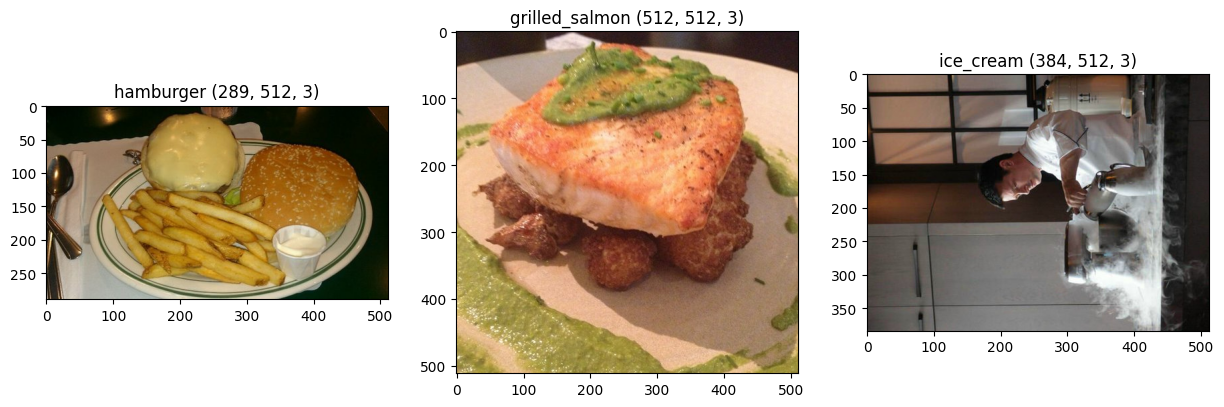

In [16]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15,7))
id = random.choice(range(0,749))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/hamburger')][id]
img = plt.imread('10_food_classes_all_data/train/hamburger/'+img_name)
plt.imshow(img)
plt.title('hamburger '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/grilled_salmon/')][id]
img = plt.imread('10_food_classes_all_data/train/grilled_salmon/'+img_name)
plt.imshow(img)
plt.title('grilled_salmon '+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/ice_cream/')][id]
img = plt.imread('10_food_classes_all_data/train/ice_cream/'+img_name)
plt.imshow(img)
plt.title('ice_cream '+str(img.shape));

In [17]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('10_food_classes_all_data/train/hamburger/')]
imagen_prueba = plt.imread('10_food_classes_all_data/train/hamburger/'+random.choice(lista_img_pizza)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (512, 382, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


### Creamos la arquitectura CNN para multi-clasificación

In [10]:
import tensorflow as tf
print(f"Version: {tf.__version__}")

Version: 2.13.0


In [18]:
tf.random.set_seed(42)

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical') #Usamos categorical para referirnos a que son más de dos clases
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical') #'sparse'

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [19]:
images, etiquetas = train_batch[0]
etiquetas [:5] #ONE HOT ENCODER

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [38]:
#Creamos la red convolucional

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 flatten_4 (Flatten)         (None, 27040)            

In [39]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [40]:
model_1.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 33s 130ms/step - loss: 2.2767 - accuracy: 0.2136 - val_loss: 2.0008 - val_accuracy: 0.2816 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 28s 121ms/step - loss: 1.9274 - accuracy: 0.3243 - val_loss: 1.9063 - val_accuracy: 0.3436 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 32s 136ms/step - loss: 1.7757 - accuracy: 0.3927 - val_loss: 1.8258 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 29s 122ms/step - loss: 1.5874 - accuracy: 0.4623 - val_loss: 1.9338 - val_accuracy: 0.3372 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 30s 127ms/step - loss: 1.3666 - accuracy: 0.5396 - val_loss: 1.9047 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 29s 123ms/step - loss: 1.1066 - accuracy: 0.6407 - val_loss: 2.1165 - val_accuracy: 0.3544 - lr: 0.0010
Epoch 7/200
235/235 [=========================

### Evaluamos el modelo

In [41]:
model_1.evaluate(test_batch)

79/79 [==============================] - 7s 89ms/step - loss: 3.0067 - accuracy: 0.3456


[3.0067238807678223, 0.3456000089645386]

### Hacemos una predicción

In [42]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/10_food_classes_all_data/test/fried_rice/1023430.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0)

y_pred = model_1.predict(img_expanded)
print(y_pred) #Softmax

1/1 [==============================] - 0s 151ms/step
[[2.1598915e-02 1.7412887e-04 4.5037702e-01 2.6745303e-03 3.1529409e-01
  8.7586150e-02 2.1139649e-03 1.1727208e-01 2.3154099e-03 5.9383042e-04]]


In [43]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

1.0

In [44]:
tf.argmax(y_pred).numpy()

2

In [45]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ") #ARGMAX

La predicción para la imagen de pizza es: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 


In [46]:
y_pred = tf.argmax(y_pred) #argmax retorna el indice del item mayor de todos los items
print(f"La clase es: {classes[y_pred]}")

La clase es: hamburger


# Ejercicio 2

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,...)
2. El tamaño del kernel de los filtros también puede crecer.
3. Podemos implementar data augmentation (más tecnicas).
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

In [50]:
#Creamos la red convolucional

model_1_new = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(10, kernel_size=(9,7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(9,7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(9,7), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1_new.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 216, 218, 10)      1900      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 108, 109, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 103, 10)      6310      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 50, 51, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 42, 45, 10)        6310      
                                                                 
 flatten_6 (Flatten)         (None, 18900)            

In [51]:
model_1_new.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [52]:
model_1_new.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 36s 141ms/step - loss: 2.3084 - accuracy: 0.1080 - val_loss: 2.3025 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 30s 127ms/step - loss: 2.3063 - accuracy: 0.0971 - val_loss: 2.3028 - val_accuracy: 0.1012 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 30s 129ms/step - loss: 2.2997 - accuracy: 0.1095 - val_loss: 2.2997 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 32s 134ms/step - loss: 2.2448 - accuracy: 0.1789 - val_loss: 2.2076 - val_accuracy: 0.2012 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 30s 128ms/step - loss: 2.1453 - accuracy: 0.2220 - val_loss: 2.2089 - val_accuracy: 0.1868 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 30s 128ms/step - loss: 1.9897 - accuracy: 0.2904 - val_loss: 2.2755 - val_accuracy: 0.1996 - lr: 0.0010
Epoch 7/200
235/235 [=========================



---



## 3. Transfer Learning

O también conocido cómo `fine tuning` es el método por el cual instanciamos una red neuronal convolucional previamente entrenada para otra tarea, pero sus filtros de más bajo nivel sirven para muchos propositos.

Nosotros tomamos esa CNN y re-entrenamos sus capas de más alto nivel para el objetivo que queremos lograr (por ejemplo clasificar comida en imágenes).

Para esto `keras` ya tiene implementado varios arquitecturas pre-entrenadas, las más conocidas son:

* AlexNet
* VGG 16
* VGG 19
* Inception
* ResNet
* EfficientNet


In [ ]:
base_model = tf.keras.applications.VGG19(include_top=False, #sin la parte dnn
                                         weights='imagenet') #EfficienteNetB0
base_model.trainable = False

In [ ]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

In [ ]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

In [ ]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
model_2.evaluate(test_batch)

>**Nota:** Vemos que la implementación de la tecnica de `Transfer Learning` con un modelo pre-entrenado mejoro sustancialmente los valores de las métricas de evaluación.

# Ejercicio 3

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. Probar otras redes pre entrenadas convolucionales: ['ResNet101','EfficientNetB0','InceptionNet']

[Link](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

#Red *ResNet101* *⚡*

In [3]:
import tensorflow as tf
from tensorflow.keras import layers


In [6]:
base_model = tf.keras.applications.ResNet101(include_top=False,
                                         weights='imagenet')
base_model.trainable = False

In [7]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x7d5acc566c80>
1 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d5a50d225c0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5a50d21ed0>
3 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5a50d21fc0>
4 <keras.src.layers.core.activation.Activation object at 0x7d5a50d23670>
5 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d5a50d233d0>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d5af0584790>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5af05849d0>
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5af0584940>
9 <keras.src.layers.core.activation.Activation object at 0x7d5af05847f0>
10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5a50d686d0>
11 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5a50d68820>
12 <keras.src

In [8]:
#Creamos la red convolucional

resnet101 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
resnet101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, None, None, 2048   42658176  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 68351114 (260.74 MB)
Trainable params: 25692938 (98.01 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


In [20]:
resnet101.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
resnet101.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 90s 316ms/step - loss: 3.1905 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 2/200
235/235 [==============================] - 67s 286ms/step - loss: 2.3047 - accuracy: 0.0916 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 3/200
235/235 [==============================] - 62s 264ms/step - loss: 2.3078 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 4/200
235/235 [==============================] - 60s 255ms/step - loss: 2.3028 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/200
235/235 [==============================] - 60s 256ms/step - loss: 2.3028 - accuracy: 0.0919 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 6/200
235/235 [==============================] - 62s 262ms/step - loss: 2.3028 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 7/200
235/235 [==============================] - 60s 254ms/step - loss: 2.3028 - accuracy: 0.0952 - val_loss: 2.3026 -

In [22]:
resnet101.evaluate(test_batch)

79/79 [==============================] - 16s 195ms/step - loss: 2.3026 - accuracy: 0.1000


[2.302581310272217, 0.10000000149011612]

In [ ]:
#Insertar ejercicio aquí...

#Red *EfficientNetB0*⚡

In [24]:
import tensorflow as tf
from tensorflow.keras import layers


In [25]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                         weights='imagenet')
base_model.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


In [26]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x7d5af0648580>
1 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d5af0648820>
2 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7d5a50b00a00>
3 <keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7d5af0648ac0>
4 <keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7d5a40adbeb0>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d5ae75347f0>
6 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5a4d31cca0>
7 <keras.src.layers.core.activation.Activation object at 0x7d5ae7536e00>
8 <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7d5a4d3464a0>
9 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d5af0e75e40>
10 <keras.src.layers.core.activation.Activation object at 0x7d5ae75b9ba0>
11 <keras.src.layers.pooling.global_average_pooling2d.GlobalAverag

In [27]:
#Creamos la red convolucional

efficientnetB0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
efficientnetB0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               16056576  
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 20108717 (76.71 MB)
Trainable params: 16059146 (61.26 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [28]:
efficientnetB0.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
efficientnetB0.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 46s 163ms/step - loss: 4.5005 - accuracy: 0.1005 - val_loss: 2.5260 - val_accuracy: 0.1000
Epoch 2/200
235/235 [==============================] - 35s 147ms/step - loss: 2.4703 - accuracy: 0.1019 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/200
235/235 [==============================] - 36s 154ms/step - loss: 2.3092 - accuracy: 0.0991 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/200
235/235 [==============================] - 40s 170ms/step - loss: 2.3027 - accuracy: 0.0952 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/200
235/235 [==============================] - 35s 147ms/step - loss: 2.3027 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/200
235/235 [==============================] - 35s 147ms/step - loss: 2.3028 - accuracy: 0.0933 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/200
235/235 [==============================] - 35s 148ms/step - loss: 2.3028 - accuracy: 0.0912 - val_loss: 2.3026 -

In [29]:
efficientnetB0.evaluate(test_batch)

79/79 [==============================] - 9s 109ms/step - loss: 2.3026 - accuracy: 0.1000


[2.3025901317596436, 0.10000000149011612]

#Red *'InceptionNet*⚡

In [30]:
import tensorflow as tf
from tensorflow.keras import layers


In [31]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                         weights='imagenet')
base_model.trainable = False

219055592/219055592 [==============================] - 10s 0us/step


In [32]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x7d59f595c850>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d59ac32f520>
2 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d59ac32f7f0>
3 <keras.src.layers.core.activation.Activation object at 0x7d5acc1c6710>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d59f646d1b0>
5 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d59f646caf0>
6 <keras.src.layers.core.activation.Activation object at 0x7d59f646d5a0>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d59f646fcd0>
8 <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7d59f646ff10>
9 <keras.src.layers.core.activation.Activation object at 0x7d59f646eb30>
10 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7d59f646fca0>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7d59f646d510>
12 <keras.src.layers.normalization.b

In [34]:
#Creamos la red convolucional

incpetionnet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
incpetionnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 flatten_2 (Flatten)         (None, 38400)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               9830656   
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 64169962 (244.79 MB)
Trainable params: 9833226 (37.51 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [35]:
incpetionnet.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
incpetionnet.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 82s 290ms/step - loss: 2.2380 - accuracy: 0.6727 - val_loss: 0.6820 - val_accuracy: 0.7744
Epoch 2/200
235/235 [==============================] - 57s 240ms/step - loss: 0.7178 - accuracy: 0.7789 - val_loss: 0.6237 - val_accuracy: 0.8020
Epoch 3/200
235/235 [==============================] - 56s 237ms/step - loss: 0.5527 - accuracy: 0.8284 - val_loss: 0.5664 - val_accuracy: 0.8236
Epoch 4/200
235/235 [==============================] - 56s 237ms/step - loss: 0.4291 - accuracy: 0.8568 - val_loss: 0.7034 - val_accuracy: 0.8028
Epoch 5/200
235/235 [==============================] - 56s 238ms/step - loss: 0.3663 - accuracy: 0.8793 - val_loss: 0.5549 - val_accuracy: 0.8252
Epoch 6/200
235/235 [==============================] - 57s 240ms/step - loss: 0.2972 - accuracy: 0.9048 - val_loss: 0.6310 - val_accuracy: 0.8152
Epoch 7/200
235/235 [==============================] - 56s 237ms/step - loss: 0.2234 - accuracy: 0.9257 - val_loss: 0.6611 -

In [36]:
efficientnetB0.evaluate(test_batch)

79/79 [==============================] - 8s 102ms/step - loss: 2.3026 - accuracy: 0.1000


[2.3025901317596436, 0.10000000149011612]